## Fine-tuning Transfer Learning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Fine-tuning is a type of transfer learning where you:

Start with a pre-trained model (e.g., ResNet, BERT, GPT).

Adjust its parameters (weights) by continuing training on your smaller, task-specific dataset.

In this section you can optionally:

1. Freeze some layers (e.g., early layers that detect generic features like edges/word syntax).

2. Train the entire model end-to-end with a lower learning rate.

OR

3. Update only the later layers (more task-specific features like organs in X-rays or sentiment in reviews), which we have already implemented in the previous notebook.



Let us first import TensorFlow and che its version:

In [ ]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


And then check if we are using either GPU or CPU?

In [ ]:
!nvidia-smi

Tue Oct  7 13:51:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Also, we have to download the module `helper_functions.py module`:

In [ ]:
import os

# GitHub raw URL of the module
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py"
filename = "helper_functions.py"

# Download only if not already present
if not os.path.exists(filename):
    print(f"Downloading {filename} from GitHub...")
    !wget -q -O {filename} {url}
    print(f"Downloaded {filename} to the current directory.")
else:
    print(f"{filename} already exists in the current directory.")

Downloaded helper_functions.py to the current directory.


In [ ]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Now download data as we did in the previous notebook.

In [ ]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

# OR alternatively

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

--2025-10-07 13:51:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 74.125.24.207, 172.217.70.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.2MB/s    in 8.0s    

2025-10-07 13:51:19 (20.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Typically the file structure should be like:

```
10_food_classes_10_percent/          <- parent directory
├── train                            <- training images
│   ├── pizza
│   │   │   1647351.jpg
│   │   │   1647352.jpg
│   │   │   ...
│   └── steak
│       │   1648001.jpg
│       │   1648050.jpg
│       │   ...
│
└── test                             <- testing images
    ├── pizza
    │   │   1001116.jpg
    │   │   1507019.jpg
    │   │   ...      
    └── steak
        │   100274.jpg
        │   1653815.jpg
        │   ...
```

In [ ]:
import tensorflow as tf

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Calling a TensorFlow utility above (`tf.keras.preprocessing.image_dataset_from_directory`), we simply and quickly build a dataset of images from a folder structure.

If you want to see an example batch of data, you could use the `take()` method.

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[253.35715    189.          67.07143   ]
   [251.11734    186.04591     60.33163   ]
   [251.79591    182.21428     54.438774  ]
   ...
   [178.99448    110.147514    15.576304  ]
   [139.26012     68.85704      2.6378064 ]
   [118.443344    44.38724      4.224261  ]]

  [[253.28572    191.28572     69.        ]
   [252.86736    189.          64.80612   ]
   [252.41327    186.58675     58.82653   ]
   ...
   [167.48946     90.8313      15.974377  ]
   [130.58661     52.724346     3.8061137 ]
   [108.305695    27.902672     0.82648516]]

  [[252.64796    195.29082     69.86224   ]
   [251.9847     193.30103     67.28571   ]
   [252.2602     193.42857     64.92347   ]
   ...
   [134.79562     53.795597     1.0101011 ]
   [108.40303     26.331589     0.        ]
   [110.30104     26.020405     2.5868273 ]]

  ...

  [[  0.           0.           2.        ]
   [  0.           0.           2.        ]
   [  0.           0.           2.        ]
   ...
   [  0.           0.   

Now we are ready to launch our first model (the baseline)...

We’ll use the `tf.keras.applications` module, which provides a collection of pre-trained computer vision models (trained on ImageNet), along with the Keras Functional API to build our model. But what are the right steps one should take...?

Model 0: Building a transfer learning model using the Keras Functional API

In order to create a baseline in our case, you can do as follows:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetV2B0` and setting the `include_top` parameter to `False`.
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model (data shape expected by the model)
4. Normalize the inputs to our model if it requires (e.g., `EfficientNetV2B0`).
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors)
7. Create an output activation layer via `tf.keras.layers.Dense()`
8. Merge the inputs and outputs layer into a new model using `tf.keras.Model()`
9. Compile the model, passing the loss function and optimizer
10. Fit the model for as many epochs as necessary.

In [ ]:
# Create base model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# Freeze base model layers
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model
x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# Create the activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Merge inputs and outputs into a new model via Model()
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.15 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="model_0_baseline")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: training_logs/model_0_baseline/20251007-135128
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2676 - loss: 2.1267 - val_accuracy: 0.7102 - val_loss: 1.3927
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.7107 - loss: 1.2576 - val_accuracy: 0.7756 - val_loss: 0.9786
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7926 - loss: 0.9302 - val_accuracy: 0.8324 - val_loss: 0.7785
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8580 - loss: 0.7107 - val_accuracy: 0.8409 - val_loss: 0.6508
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8435 - loss: 0.6408 - val_accuracy: 0.8580 - val_loss: 0.5783


What we did exactly is:

We took our custom dataset, fed it into a pre-trained model (`EfficientNetV2B0`), let it identify meaningful patterns, and then added our own output layer to match the number of classes we needed.

Keras Functional API is used instead of using the Sequential one to create the model.

### Model Inspection

Before proceeding with model inspection, it is important to note that the model is currently in the process of being fine-tuned, and as such, its weights and configurations may not fully reflect the final intended setup. At this stage, we will focus on examining the model’s architecture and layer structure to better understand its components, verify the expected configuration, and ensure that the fine-tuning process is applied to the correct parameters.


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

What about he summary of the model we just constructed?

In [ ]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

**NOTE!** A pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

As you can see, the only trainable parameters in the model are those in the output layer.



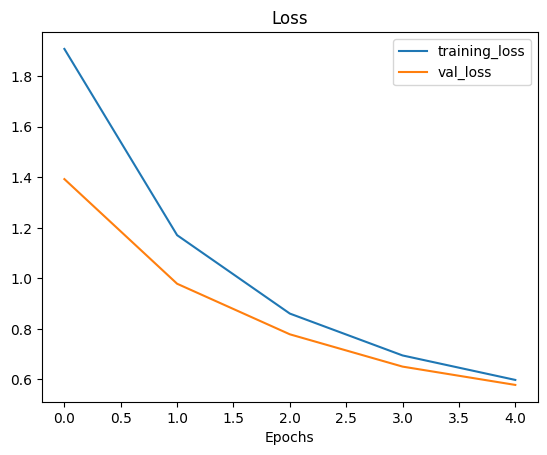

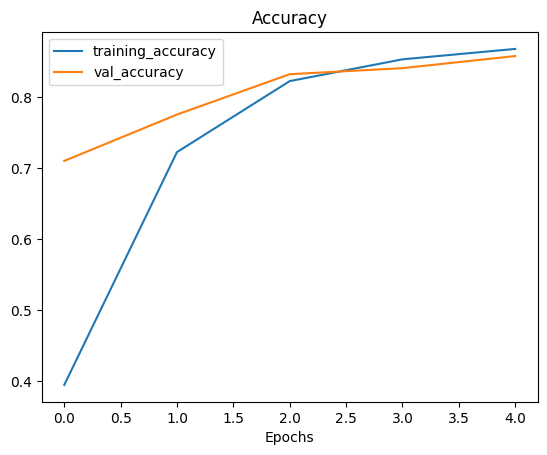

In [ ]:
plot_loss_curves(history_0)

### Extract a Feature Vector

Now let us see what a single feature vector of a trained model might look like...



In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


**Why use `GlobalAveragePooling2D()`?**

- Prevents overfitting (fewer parameters vs. Flatten + Dense).
- Reduces computation.
- Works well for classification tasks by keeping only the presence of a feature, not its exact location.

The operation above can also be replicated by `tf.reduce_mean()`, specifying the right axis.

In [ ]:
# the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Transfer Learning Experiments

We’ve already observed impressive results from transfer learning using just 10% of the training data. But what happens if we shrink that to only 1%?

Can transfer learning still deliver strong performance when using 100x less data than the CNN models we trained from scratch?

To find out, we’ll run the following experiments:

**Model 1**: Apply feature extraction with transfer learning on 1% of the training data, using data augmentation.

**Model 2**: Apply feature extraction with transfer learning on 10% of the training data, with data augmentation, and save a checkpoint.

**Model 3**: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.

**Model 4**: Fine-tune the Model 2 checkpoint on the full training dataset with data augmentation.

Although the models will train on different subsets of the data, all results will be evaluated against the same test set to ensure fair comparison.

All experiments will use `EfficientNetV2B0` from the `tf.keras.applications.efficientnet_v2 module`.

We will also use `create_tensorboard_callback()` function to log all of the model training logs to make sure we're keeping track of our experiments.

Then let's first download the data for **experiment 1**:

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2025-10-07 13:52:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.3MB/s    in 6.8s    

2025-10-07 13:52:47 (18.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Investigate the directories and number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

**Oh no!** Looks like we've only got seven images of each class, this should be a bit of a challenge for our model.

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE
                                                                           )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Transfer Learning on 1% of the Training Data, Using Data Augmentation

To apply augmentation this time, we’ll integrate it directly into the model by using the tf.keras.layers module and setting up a dedicated data augmentation layer.

Incorporating a data augmentation layer into the model provides several advantages:

- Image preprocessing (augmentation) is executed on the GPU instead of the CPU, resulting in significantly faster performance.

  - While images benefit from GPU-based preprocessing, text and structured data are generally better handled on the CPU.

- Image augmentation occurs only during training, allowing the entire model to be exported and used elsewhere without issue. This also ensures that others can retrain the model with the same augmentation strategy if needed.

**ADDITIONAL NOTE!**

Keras gives you several ways to create models depending on how much control or flexibility you need.

1. Sequential API
  - The simplest way to build a model in Keras.
  - You just stack layers one after another.
  - Best for linear flow models (input → hidden layers → output), no branches or multiple inputs/outputs.

  ✅ Easy, readable, quick prototyping. \
  ❌ Limited — can’t handle complex architectures (e.g., models with multiple inputs, outputs, or shared layers).

2. Functional API

- More flexible.
- You explicitly define inputs and outputs and can build models with non-linear flows: multiple inputs, multiple outputs, shared layers, residual connections, etc.

✅ Great for complex architectures. \
✅ Very explicit — you see the full computational graph. \
❌ A bit more verbose than Sequential

3. Model Subclassing (Custom Class)

- You define your model as a Python class by subclassing tf.keras.Model.
- Gives maximum flexibility — you can write your own forward pass (call() method), conditional logic, loops, etc.

✅ Ideal for research, custom architectures, dynamic computation. \
❌ More code, less beginner-friendly.

4. Model with `Sequential + Functional` Hybrid \
Sometimes you mix — e.g., use Sequential blocks inside a Functional API model for modularity.

We can apply data augmentation directly in our model by building a **Keras Sequential** model that contains only preprocessing layers. This Sequential model can then be integrated into a larger **Functional** model.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  # layers.Resizing(224, 224),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

Now, in order to tets it out, we can pass random images through it and see the result.

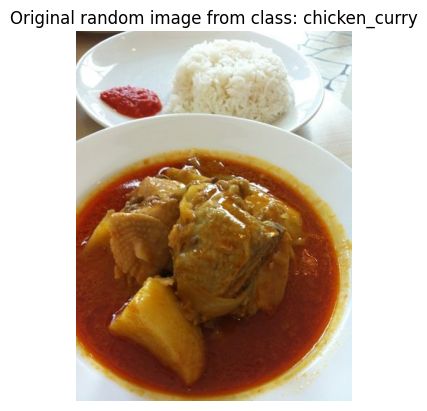

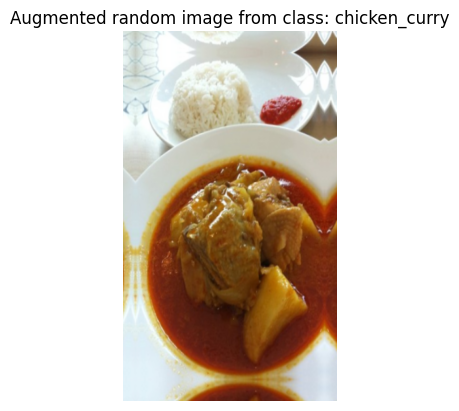

In [ ]:
# Pick and display a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Apply augmentation to the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Just in case you were wondering what changes after dimension expansion is applied:

In [ ]:
print(f"Image shape before expansion: {img.shape}")
print(f"Image shae after expansion: {tf.expand_dims(img, axis=0).shape}")

Image shape before expansion: (512, 382, 3)
Image shae after expansion: (1, 512, 382, 3)


### MODEL 1: Feature extraction TL on 1% of the data + data augmentation

In [ ]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input Layer
inputs = layers.Input(shape=input_shape, name="input_layer")
print(inputs.shape)
# Data Augmentation (Pre-processing)
x = data_augmentation(inputs)

# Pass the input into the base model
x = base_model(x, training=False)
# Apply average pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Add a dense layer to collect output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model
model_1 = keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="model_1_feature_extraction_1_percent_data_augmentation")])

(None, 224, 224, 3)
Saving TensorBoard log files to: training_logs/model_1_feature_extraction_1_percent_data_augmentation/20251007-135912
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.0787 - loss: 2.4588 - val_accuracy: 0.2072 - val_loss: 2.1955
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1885 - loss: 2.2213 - val_accuracy: 0.2895 - val_loss: 2.0760
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 832ms/step - accuracy: 0.3875 - loss: 2.0263 - val_accuracy: 0.3849 - val_loss: 1.9814
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4343 - loss: 1.8815 - val_accuracy: 0.4424 - val_loss: 1.8851
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6808 - loss: 1.7281 - val_accuracy: 0.5016 - val_loss: 1.7946


In [ ]:
model_1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [ ]:
# Evaluate the model on test data
results_1 = model_1.evaluate(test_data)
results_1

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4953 - loss: 1.8060


[1.8201733827590942, 0.4812000095844269]

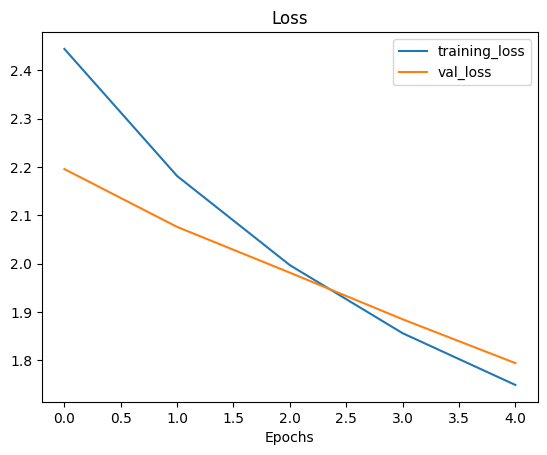

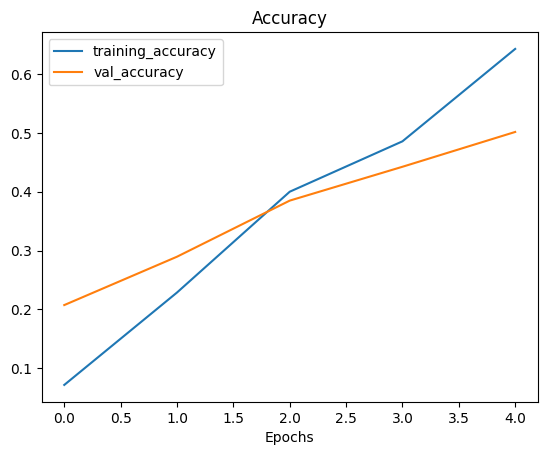

In [ ]:
# Now let us plot it and see the performance graph
plot_loss_curves(history_1)

### MODEL 2: Feature extraction TL on 10% of the data + data augmentation

Practically speaking, as we’ve discussed, aim to minimize the time between experiments. Run many small tests with limited data and fewer training iterations until you find something promising, then scale it up.

On that note, let’s expand our previous 1% training data augmentation experiment to 10%. That phrasing might sound odd, but you get the idea.

We’ll follow the same steps as before—the only change is using 10% of the training data instead of 1%.

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Not necessary to create test data since it already exists
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.Resizing(224, 224),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

In [ ]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
# Augment the training images
x = data_augmentation(inputs)
# Pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

There is  also a nicer way to create an instance of your model. Below you can find out how...

In [ ]:
# Define a function which returns the model
def create_model(input_shape: tuple[int, int, int]=(224, 224, 3),
                 output_shape: int = 10,
                 learning_rate: float = 0.001,
                 training=False) -> tf.keras.Model:
  """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
  """

  # Create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = training

  # Setup model input and outputs with data augmentation built-in
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = data_augmentation(inputs)
  x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])

  return model


model_2 = create_model()

To save the model at specific intervals (e.g., after each epoch or when validation accuracy improves), one can also create a **ModelCheckpoint** callback so they can:

- Resume training later
- Restore the best model and not just the last one
- Avoid manual model saving

The ModelCheckpoint callback in TensorFlow (Keras) is a built-in utility that allows you to automatically save your model or its weights during training — typically after each epoch or whenever a certain performance metric improves.

It’s part of TensorFlow’s tf.keras.callbacks module and helps prevent losing progress or overfitting by keeping the best-performing model checkpoints.

In [ ]:
# Setup path for your checkpoints
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

It is time to fit our model given the 10% data at hand for now.

In [ ]:
# Fit the model
# It will save checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20251007-140037
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.2436 - loss: 2.1521
Epoch 1: val_loss improved from inf to 1.51868, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 526ms/step - accuracy: 0.2474 - loss: 2.1460 - val_accuracy: 0.6069 - val_loss: 1.5187
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6140 - loss: 1.5100
Epoch 2: val_loss improved from 1.51868 to 1.11090, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 399ms/step - accuracy: 0.6146 - loss: 1.5074 - val_accuracy: 0.7253 - val_loss: 1.1109
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7334 - loss: 1.1273
Epoch 3: val_loss improved from 1.11090 to 0.88933, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 425ms/step - a

In [ ]:
# Evaluate on the test data
results_2 = model_2.evaluate(test_data)
results_2

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8028 - loss: 0.7039


[0.6881178021430969, 0.8167999982833862]

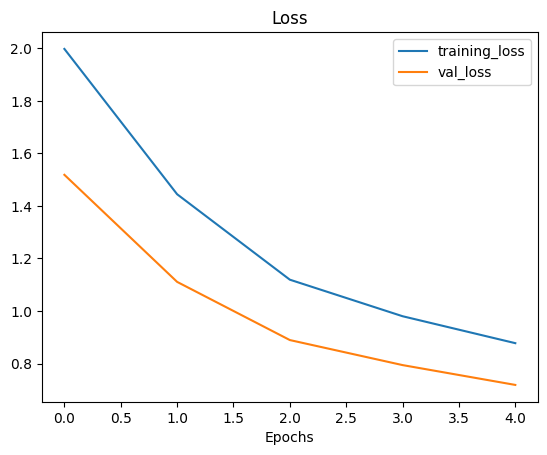

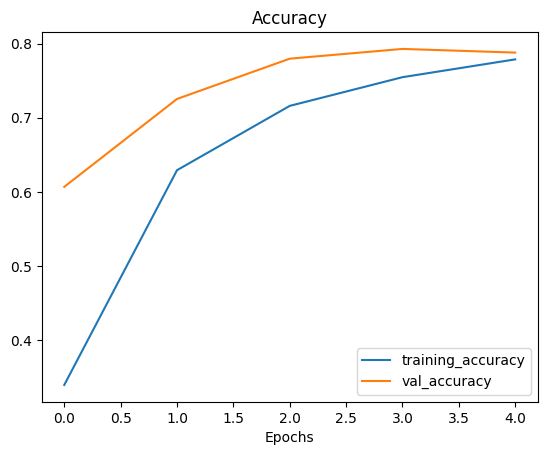

In [ ]:
# Plot loss curves
plot_loss_curves(history_2)

To load saved model weights you can use the the `load_weights()` method, passing only the path where it has been saved.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8082 - loss: 0.7002


In [ ]:
results_2 == loaded_weights

False

Since the above cell did not output `False`, the results are valid. But you should also remember that the values produced are not exactly the same considering them in full precision (they are stored with a certain degree of precision). You can also gain assurance via the code snippet below:

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_2), np.array(loaded_weights))

array([ True,  True])

In [ ]:
# Check the difference between the two results (if present, small values are expected)
print(np.array(results_2) - np.array(loaded_weights))

[-2.98023224e-07  0.00000000e+00]


### Model 3: Fine-tuning the latest model on 10% of the data (Partially Fine-Tuning Base Model)

We have previously seen and learned how Fine-tuning and Feature Extraction TL are implemented. For the next experiment, we would like to take the stored model (from the last experiment) and unfreeze some of its base model's layers (closest to the top) in order to fine-tune it running the model for a few more epochs. Note that base model basically refers to `efficientnetv2-b0` which has already got several layers of parameters.

**Additional Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data.

In [ ]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [ ]:
# Extract useful information of each layer
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <InputLayer name=input_layer, built=True> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <Sequential name=data_augmentation, built=True> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <Functional name=efficientnetv2-b0, built=True> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <Dense name=output_layer, built=True> | Trainable? True


In [ ]:
# Model summary
model_2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

From the number of trainable values, it can be easily understood that only the dense output layer is set as trainable